# Probabalisitc PCA (PPCA) on the MNIST dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io 
from sklearn.manifold import TSNE
from scipy.linalg import orth
from glob import glob
from sklearn.metrics import mean_squared_error
from tensorflow.keras.datasets import mnist
from sklearn.manifold import TSNE

## PPCA Introduction

Principal Component Analysis (PCA) is a well-established and widely used dimensionality reduction technique which basically takes an orthogonal projection of the data to a lower-dimensional space and also allows for well-approximated reconstruction.

Probabilistic PCA (PPCA), as the name suggests is the probabilistic formulation of this method as a **Gaussian latent variable model** i.e both the prior for the latent variable and the conditional distribution of observed data w.r.t latents are modelled as Gaussian.

              p(z) = N(z|0,I)
              p(x|z) = N (x|Wz + μ, σ²I)

effectively, the marginal distribution for the observed data is given by

              p(x) = N(x|μ,C) where C = WWᵀ + σ²I

This is used to get the log-likelihood which can then be used to get the MLEs for the parameters (`μ,W,σ²`). The MLE estimators of `W` (and `σ²`) correspond to the regular PCA.

**Another alternative approach** to get the estimates of the parameters is to use an iterative expectation-maximisation(EM) algorithm. This method reduces the computation work as we dont need to compute the eigenvectors of the covariance matrix (`XXᵀ`).

**This notebook implements this approach and analyzes its results by making reconstruction plots, loss plots and checks for the grouping property**

## EM algorithm for estimating MLEs for PPCA

In this algorithm, the latent variables are treated as missing(or unobserved) and the input data as filled(or observed) of joint data(X,Z). 


Then the algorithm tries to maximize the log-likelihood the joint distribution `p(x,z)`.



* In the E step, expectation(or mean) of latent variables(`Z`) is estimated




* The estimated values of the latent data are then used to update the parameters(`W,σ²`)  by maximizing log-likelihood of `p(x,z)`.

In this notebook we are assuming zero noise-variance(`σ²~0`) so the only learnable parameter is the weight matrix(`W`)

The summarized steps of the above EM algorithm are

```
Z = (WᵀW)⁻¹Wᵀ X --> E-step
W = XZᵀ(ZZᵀ)⁻¹  --> M-step
```



## Loading the MNIST dataset

In [ ]:
# We are using 1000 mnist samples for our dimensionality reductions using PPCA
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

N = 1000
train_images = train_images[0:N,:,:]
test_images = test_images[0:N,:,:]
_, nrows, ncols = train_images.shape
X = np.reshape(train_images, (N, nrows*ncols)).T 
X.shape

X_test = np.reshape(test_images, (N, nrows*ncols)).T
print('train_data shape: ',X.shape, 'test_data shape: ',X_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
train_data shape:  (784, 1000) test_data shape:  (784, 1000)


## Estimating the PPCA parameters using EM.

Assuming zero-variance noise

In [ ]:
def check_convergence(cur_value, old_value, threshold):
  diff = np.abs(cur_value - old_value)
  avg = (cur_value + old_value)/2
  return (diff/avg) < threshold

In [ ]:
def ppca_transform(X, L, reconstructed=False):
  D,N = X.shape
  rng = np.random.default_rng(678)
  W = rng.uniform(size=(D,L))

  convg = False
  new_mseloss = np.inf
  while not convg:
    old_mseloss = new_mseloss
    Z = np.linalg.lstsq(np.dot(W.T, W), np.dot(W.T, X),rcond=-1)[0] # E-step
    X_recon = np.dot(W, Z)
    W = np.dot(X, Z.T)@np.linalg.inv(np.dot(Z, Z.T)) # M-step
    
    new_mseloss = mean_squared_error(X, X_recon)

    np.warnings.filterwarnings('ignore')
    convg = check_convergence(new_mseloss, old_mseloss, 1e-2)

  if reconstructed:
    return X_recon
  else:
     return Z,W

## Sample reconstructions

In [ ]:
# Rank of the matrix.
X_rank = np.linalg.matrix_rank(X.T)
X_rank

590

In [ ]:
def show_recons(X, X_recon,L,recon_error):
  fig, ax = plt.subplots(1,10,figsize=(20,3))
  plt.suptitle(f'latent_dims={L} and recon_error={recon_error}')
  for i in range(0,10,2):
    ax[i].title.set_text('original')
    ax[i].imshow(X[:,i].reshape(nrows,ncols), cmap='gray')
    ax[i+1].title.set_text(f'recon')
    ax[i+1].imshow(X_recon[:,i].reshape(nrows,ncols), cmap='gray')
  plt.show()

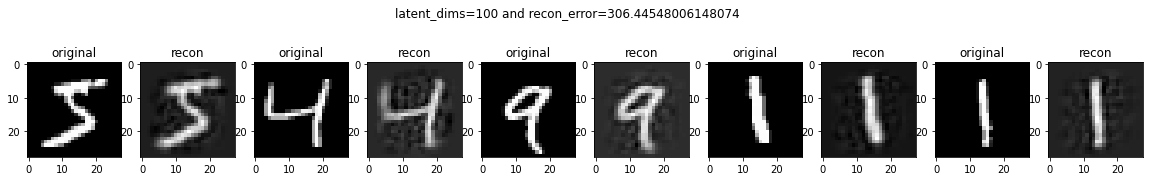

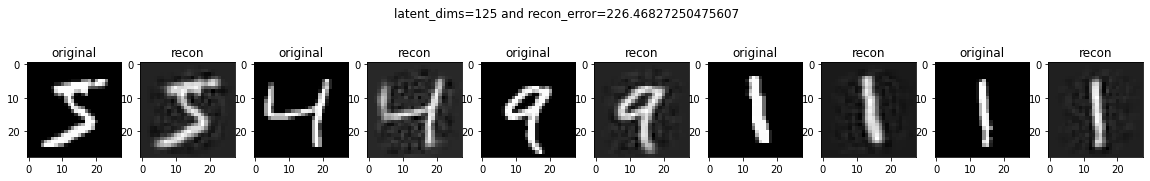

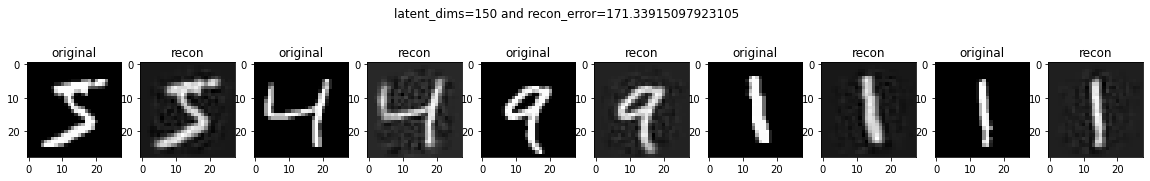

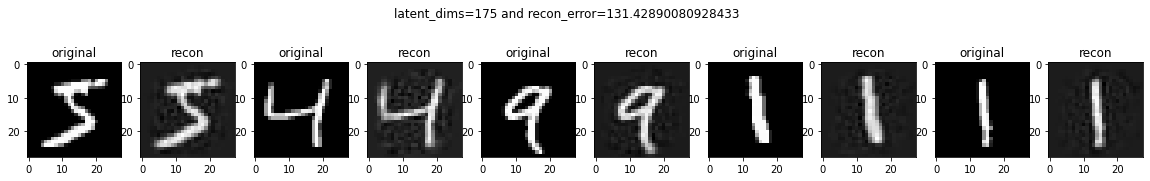

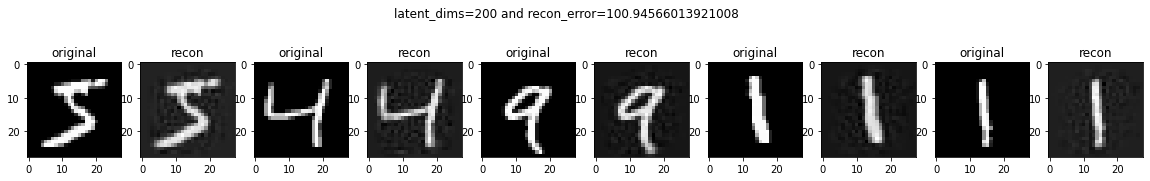

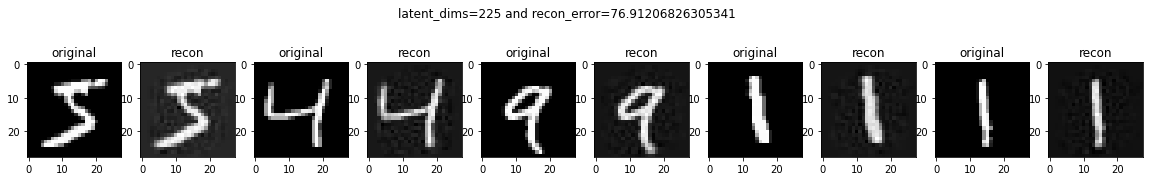

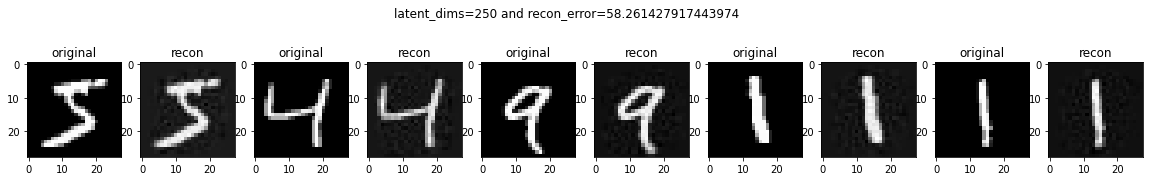

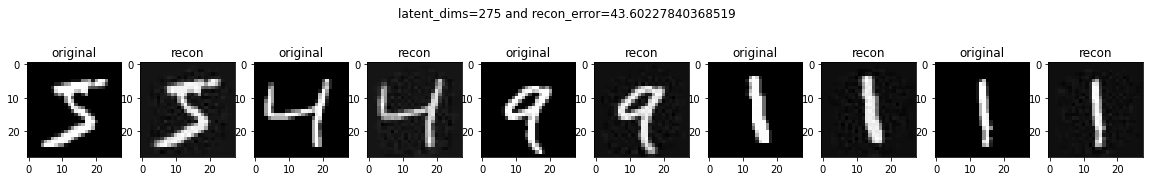

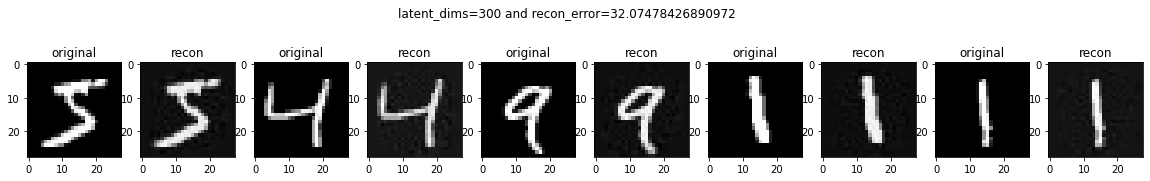

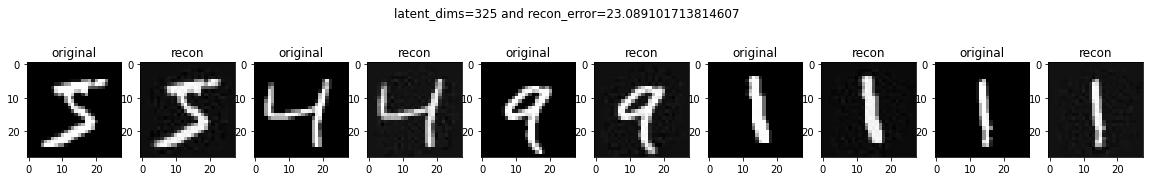

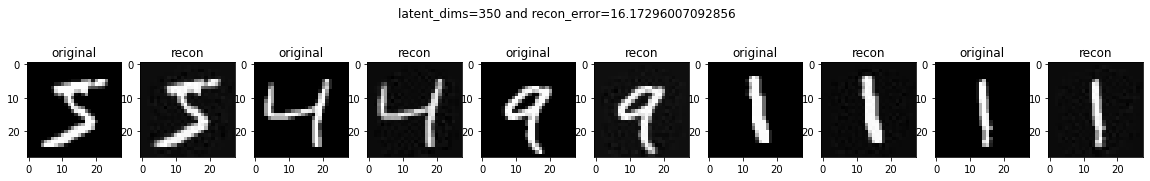

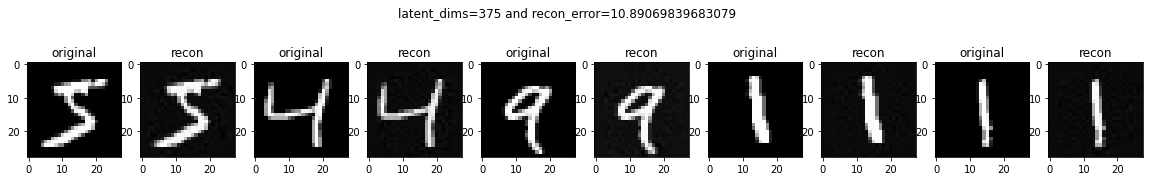

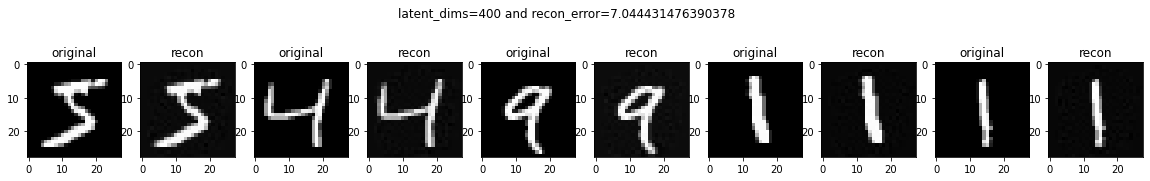

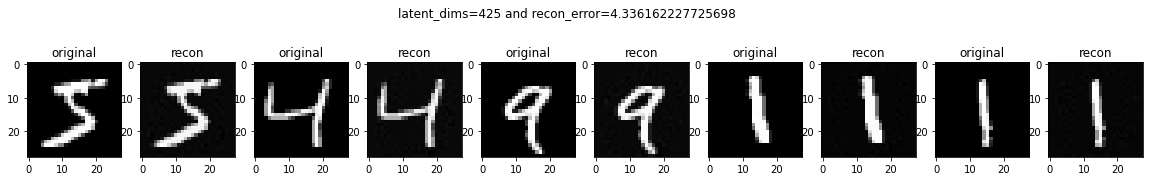

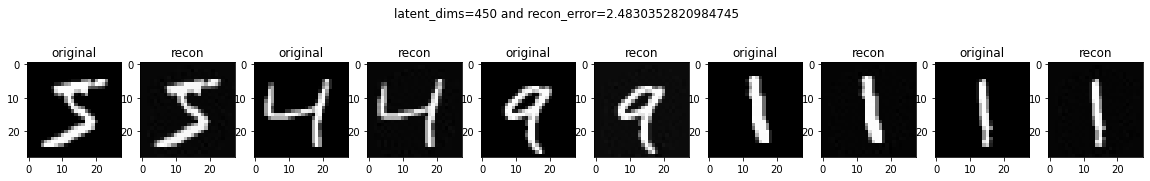

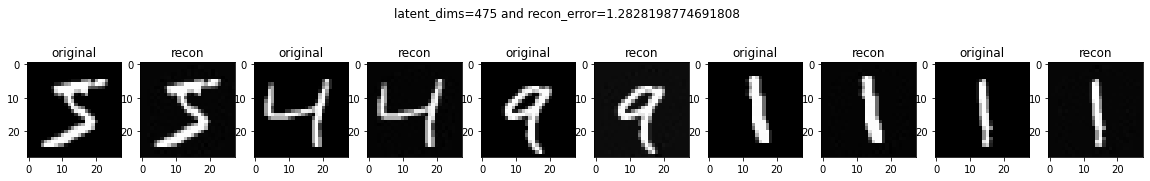

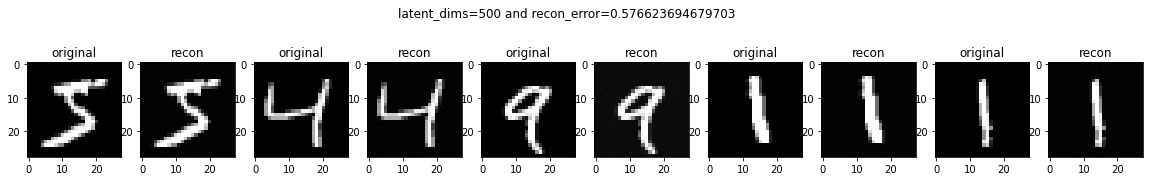

In [ ]:
# Reconstructed images for training set (first 5 are shown)
latent_dims = np.arange(501,step=25)[4:]
recon_errors = []
for L in latent_dims:
  X_recon = ppca_transform(X,L,reconstructed=True)
  recon_error = mean_squared_error(X, X_recon)
  show_recons(X, X_recon,L,recon_error)
  recon_errors.append(recon_error)

### Reconstruction-error plot
It can be observed that the error decreases as the no of latent-dimensions increase(i.e, the no. of Principal Components) and it converges to zero as it reaches the rank of the matrix (here, rank=590).

This is because the no. of non-zero eigen values is equal to the rank of the data matrix and that is the maximum no. of principal axes that can be considered. (But the reconstruction loss continues even beyond the rank in PCA).

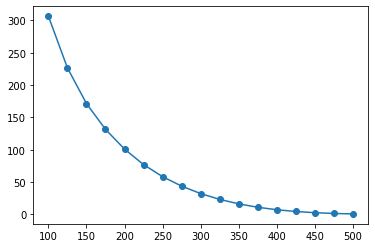

In [ ]:
plt.plot(latent_dims, recon_errors,'-o'); plt.show()

## Checking grouping property using t-SNE plots


It can be observed in the t-SNE plots that all the clustering (points of same color being in proximity) is preserved in the embedded form of our latent(ppca-transformed) data.

In the plot, each color corresponds to a label.

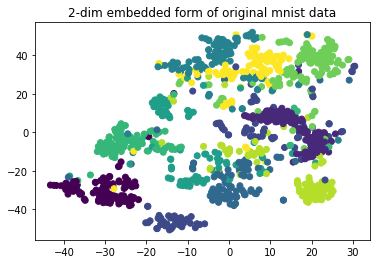

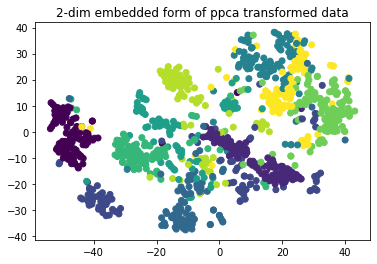

In [ ]:
L = 300
Z,W = ppca_transform(X, L, reconstructed=False)

# t-SNE plot for X
embedded_X = TSNE(n_components=2, random_state=1).fit_transform(X.T)
# t-SNE plot for Z
embedded_Z = TSNE(n_components=2, random_state=1).fit_transform(Z.T)
# checking whether latent variables are also clustered.
plt.title('2-dim embedded form of original mnist data')
plt.scatter(embedded_X[:,0], embedded_X[:,1],c=train_labels[:N]); plt.show()
plt.title('2-dim embedded form of ppca transformed data')
plt.scatter(embedded_Z[:,0], embedded_Z[:,1],c=train_labels[:N]); plt.show()

## References:
* [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html), *Kevin P. Murphy*

* Michael E. Tipping and Christopher M. Bishop. [Probabilistic principal component analysis](http://www.cs.columbia.edu/~blei/seminar/2020-representation/readings/TippingBishop1999.pdf). Journal of the Royal Statistical Society: Series B (Statistical Methodology), 61(3): 611-622, 1999.
